In [1]:
import os, sys; sys.path.append(os.getcwd())

from src.api import get_latest_block, chunked_get_logs
from src.prices import binance_daily
from src.features import liq_daily_count, merge_ret_vs_liq



In [16]:
import requests

r = requests.get(BASE, params={
    "chainid": 1,
    "module": "block",
    "action": "getblockreward",
    "blockno": 18000000,
    "apikey": API_KEY
})
r.json()


{'status': '1',
 'message': 'OK',
 'result': {'blockNumber': '18000000',
  'timeStamp': '1693066895',
  'blockMiner': '0xdafea492d9c6733ae3d56b7ed1adb60692c98bc5',
  'blockReward': '30697207500857250',
  'uncles': [],
  'uncleInclusionReward': '0'}}

In [17]:
from Crypto.Hash import keccak

# Aave v2 事件签名（7个参数）
sig = b"LiquidationCall(address,address,address,uint256,uint256,address,bool)"
k = keccak.new(digest_bits=256); k.update(sig)
TOPIC0 = "0x" + k.hexdigest()
TOPIC0


'0xe413a321e8681d831f4dbccbca790d2952b56f977908e45be37335533e005286'

In [18]:
latest_block = get_latest_block(chainid=1, base=BASE, api_key=API_KEY)
latest_block

23583808

In [19]:
from_block = max(1, latest_block - 2_000_000)  # 最近约 200 万个区块
logs = chunked_get_logs(
    address=POOL,
    topic0=TOPIC0,
    from_block=from_block,
    to_block=latest_block,
    step=50_000,
    base=BASE,
    api_key=API_KEY,
    chainid=1
)
len(logs)

100%|██████████████████████████████████████████████████| 40/40 [01:29<00:00,  2.23s/it]


7832

In [26]:
import pandas as pd, numpy as np, time, os, json, requests

CACHE_PATH = "data/block_ts_cache.csv"
os.makedirs("data", exist_ok=True)

def fetch_block_ts(block_no: int) -> int:
    r = requests.get(BASE, params={
        "chainid": 1,
        "module": "block",
        "action": "getblockreward",
        "blockno": block_no,
        "apikey": API_KEY
    }, timeout=20).json()
    return int(r["result"]["timeStamp"])

# 1) 先取日志里的所有区块号（去重、排序）
uniq_blocks = sorted({int(lg["blockNumber"], 16) for lg in logs})
print("unique blocks:", len(uniq_blocks))

# 2) 读取/初始化缓存
if os.path.exists(CACHE_PATH):
    cache = pd.read_csv(CACHE_PATH)
    cache = dict(zip(cache["blockNumber"], cache["timestamp"]))
else:
    cache = {}

# 3) 选“锚点区块”：首尾 + 每 step_anchor 个
step_anchor = 200
anchors = sorted(set([uniq_blocks[0], uniq_blocks[-1]] + uniq_blocks[::step_anchor]))
print("anchor count:", len(anchors))

# 4) 拉取锚点区块的真实时间戳（带缓存）
for b in anchors:
    if b in cache: 
        continue
    cache[b] = fetch_block_ts(b)
    time.sleep(0.2)  # 轻微限速

# 落盘缓存
pd.DataFrame({"blockNumber": list(cache.keys()), "timestamp": list(cache.values())}) \
  .to_csv(CACHE_PATH, index=False)

# 5) 用锚点做线性插值，估算所有区块的时间戳
anchor_df = pd.DataFrame({"blockNumber": list(cache.keys()), "timestamp": list(cache.values())}).sort_values("blockNumber")
anchor_df["ts"] = pd.to_datetime(anchor_df["timestamp"], unit="s", utc=True)
# 拟合：blockNumber -> timestamp（秒）
coef = np.polyfit(anchor_df["blockNumber"], anchor_df["timestamp"], 1)
# 线性函数
def est_ts(bn): 
    return int(np.polyval(coef, bn))

# 6) 生成最终行
rows = []
for lg in logs:
    bno = int(lg["blockNumber"], 16)
    ts_sec = cache[bno] if bno in cache else est_ts(bno)
    rows.append({
        "blockNumber": bno,
        "timestamp": pd.to_datetime(ts_sec, unit="s", utc=True),
        "txHash": lg["transactionHash"],
        "logIndex": int(lg["logIndex"], 16)
    })

df = pd.DataFrame(rows).sort_values(["timestamp","blockNumber","logIndex"])
df.head(), len(df)


unique blocks: 4745
anchor count: 25


(   blockNumber                 timestamp  \
 0     21586740 2025-01-09 11:52:11+00:00   
 1     21589223 2025-01-09 18:42:53+00:00   
 2     21589224 2025-01-09 18:43:05+00:00   
 3     21589429 2025-01-09 19:24:21+00:00   
 4     21589465 2025-01-09 19:31:36+00:00   
 
                                               txHash  logIndex  
 0  0x1bea9af9fd25d398f423e10e3e175d07728028eb6077...        16  
 1  0x7ef41753504130d27aad6c6863c4dfa4061839132360...        17  
 2  0x1e8a5bc7abddca4820c638465890b71f8ed0ca155339...       355  
 3  0x1c5976cec78df2cbcc4e8bb6190f6524f9728d1f2a37...        16  
 4  0x3c6f47f670a7e7c7c534df419c984b0e3db4a999a42d...       236  ,
 7832)

In [27]:
print("rows:", len(df), "unique days:", df["timestamp"].dt.date.nunique())

rows: 7832 unique days: 243


✅ saved: data/aave_liqs_ethscan.csv rows: 7832


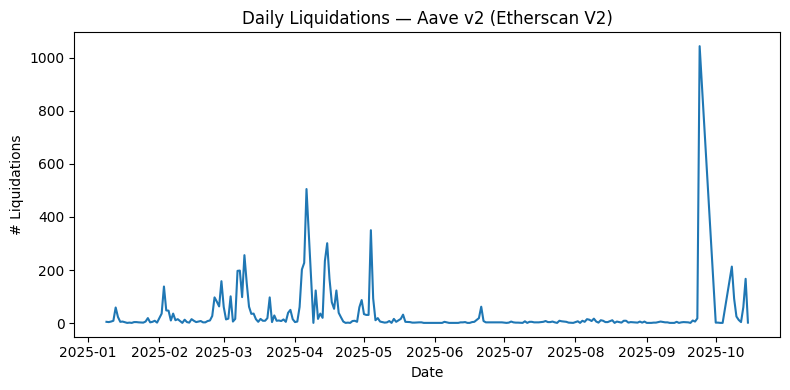

In [29]:
import os, matplotlib.pyplot as plt
os.makedirs("data", exist_ok=True)
os.makedirs("figs", exist_ok=True)

df["date"] = df["timestamp"].dt.date
df.to_csv("data/aave_liqs_ethscan.csv", index=False)
print("✅ saved:", "data/aave_liqs_ethscan.csv", "rows:", len(df))

daily = df.groupby("date").size()
plt.figure(figsize=(8,4))
daily.plot()
plt.title("Daily Liquidations — Aave v2 (Etherscan V2)")
plt.xlabel("Date"); plt.ylabel("# Liquidations")
plt.tight_layout()
plt.savefig("figs/daily_liqs.png", dpi=200)
plt.show()


In [35]:
# ✅ ETH 日线价格（使用 binance_daily 代替）
daily_px = binance_daily("ETHUSDT", 1000)
# daily_px 包含 'date', 'price', 'ret' 列
daily_px.tail()

✅ saved: data/eth_daily_price.csv rows: 1000


,date,price,ret
995,2025-10-11,3746.79,-0.021654
996,2025-10-12,4152.29,0.108226
997,2025-10-13,4240.85,0.021328
998,2025-10-14,4125.02,-0.027313
999,2025-10-15,3998.78,-0.030603


In [38]:
print("清算数据日期范围：", df['timestamp'].dt.date.min(), "→", df['timestamp'].dt.date.max())
print("价格数据日期范围：", daily_px['date'].min(), "→", daily_px['date'].max())

清算数据日期范围： 2025-01-09 → 2025-10-15
价格数据日期范围： 2023-01-20 → 2025-10-15


In [39]:
import pandas as pd

# 从前面步骤得到 df
# 使用 liq_daily_count 获取按日统计的清算次数
# df 的 timestamp 列应已存在
# daily_liq DataFrame 包含 'date' 和 'liq_cnt'
daily_liq = liq_daily_count(df)

# 获取 ETH 日线价格
# daily_px 已由 binance_daily 得到
# 如果不存在 daily_px 变量，可以重新调用：
# daily_px = binance_daily("ETHUSDT", 1000)

# 使用 merge_ret_vs_liq 合并两张表
merged = merge_ret_vs_liq(daily_px, daily_liq)

# ✅ 自动保存
merged.to_csv("data/eth_ret_vs_liq.csv", index=False)
print("✅ 合并完成! 合并后行数:", len(merged))
merged.tail(3)

🔍 清算日期范围: 2025-01-09 00:00:00 → 2025-10-15 00:00:00
🔍 价格日期范围: 2023-01-20 00:00:00 → 2025-10-15 00:00:00
✅ 合并完成! 合并后行数: 243


,date,liq_cnt,ret,price
240,2025-10-13,60,0.021328,4240.85
241,2025-10-14,167,-0.027313,4125.02
242,2025-10-15,2,-0.030603,3998.78


ret        float64
liq_cnt      int64
dtype: object
              ret      liq_cnt
count  243.000000   243.000000
mean     0.001156    32.230453
std      0.042489    89.424078
min     -0.146578     1.000000
25%     -0.023504     3.000000
50%      0.000366     6.000000
75%      0.019986    17.500000
max      0.218805  1043.000000


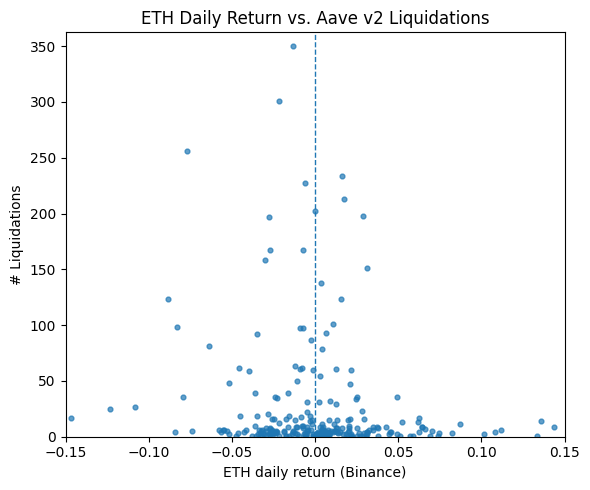

Pearson corr (ret, liq_cnt): -0.15214489990123306


In [45]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1) 清洗：确保是数值
m = merged.copy()
m["ret"] = pd.to_numeric(m["ret"], errors="coerce")
m["liq_cnt"] = pd.to_numeric(m["liq_cnt"], errors="coerce")
m = m.dropna(subset=["ret", "liq_cnt"])

print(m[["ret","liq_cnt"]].dtypes)
print(m[["ret","liq_cnt"]].describe())

# 2) 画散点（限定坐标，避免被自动缩到很小范围）
plt.figure(figsize=(6,5))
plt.scatter(m["ret"].values, m["liq_cnt"].values, s=12, alpha=0.7)
plt.axvline(0, linestyle="--", linewidth=1)
plt.xlim(-0.15, 0.15)                                   # ETH 日收益率常见范围
plt.ylim(0, max(10, m["liq_cnt"].quantile(0.99)*1.1))   # 去掉极端峰值的影响
plt.title("ETH Daily Return vs. Aave v2 Liquidations")
plt.xlabel("ETH daily return (Binance)")
plt.ylabel("# Liquidations")
plt.tight_layout()
plt.savefig("figs/ret_vs_liq_scatter.png", dpi=200)
plt.show()

# 3) 相关性
print("Pearson corr (ret, liq_cnt):", np.corrcoef(m["ret"], m["liq_cnt"])[0,1])


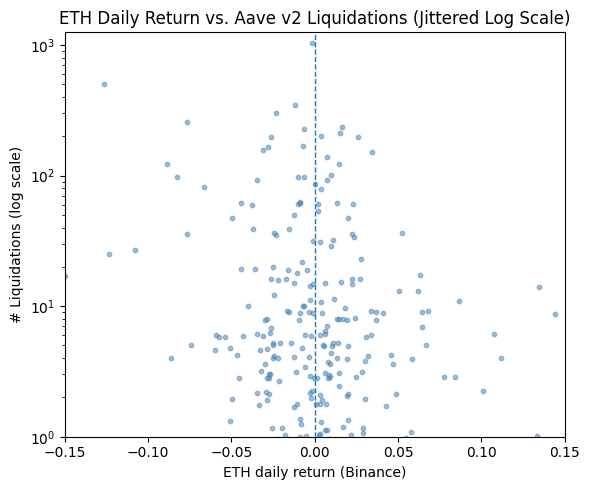

In [42]:
plt.figure(figsize=(6,5))
plt.scatter(
    m["ret"] + np.random.normal(0, 0.002, len(m)),  # X 加轻微抖动
    m["liq_cnt"] + np.random.normal(0, 0.2, len(m)), # Y 加轻微抖动
    s=10, alpha=0.5, c='steelblue'
)
plt.yscale("log")
plt.axvline(0, linestyle="--", linewidth=1)
plt.xlim(-0.15, 0.15)
plt.ylim(1, m["liq_cnt"].max()*1.2)
plt.title("ETH Daily Return vs. Aave v2 Liquidations (Jittered Log Scale)")
plt.xlabel("ETH daily return (Binance)")
plt.ylabel("# Liquidations (log scale)")
plt.tight_layout()
plt.savefig("figs/ret_vs_liq_jitter.png", dpi=200)
plt.show()


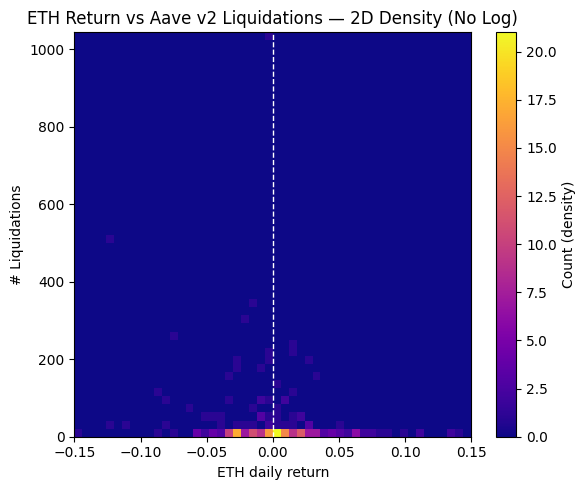

In [48]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(6,5))
plt.hist2d(
    m["ret"], m["liq_cnt"],
    bins=[50, 50],             # 分箱更平滑
    range=[[-0.15, 0.15], [0, m["liq_cnt"].max()]],
    cmap="plasma"              # 色彩更直观，可改为 viridis / magma
)
plt.colorbar(label="Count (density)")
plt.axvline(0, ls="--", lw=1, color="white")
plt.title("ETH Return vs Aave v2 Liquidations — 2D Density (No Log)")
plt.xlabel("ETH daily return")
plt.ylabel("# Liquidations")
plt.tight_layout()
plt.savefig("figs/ret_vs_liq_hist2d_nolog.png", dpi=200)
plt.show()


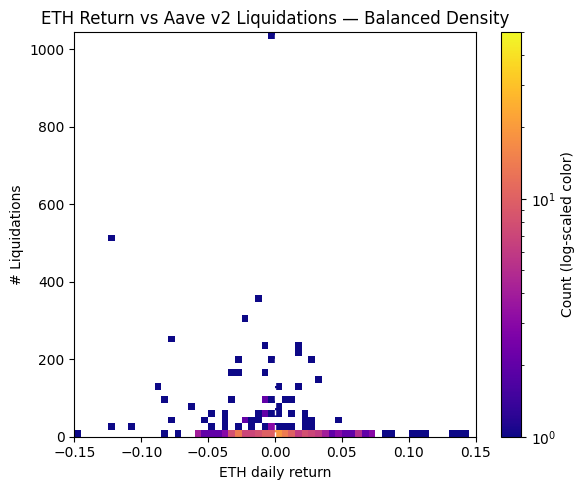

In [49]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(6,5))
plt.hist2d(
    m["ret"], m["liq_cnt"],
    bins=[60, 60],
    range=[[-0.15, 0.15], [0, m["liq_cnt"].max()]],
    norm=LogNorm(vmin=1, vmax=50),  # 👈 让色阶只对 1–50 范围做 log 压缩
    cmap="plasma"
)
plt.colorbar(label="Count (log-scaled color)")
plt.axvline(0, ls="--", lw=1, color="white")
plt.title("ETH Return vs Aave v2 Liquidations — Balanced Density")
plt.xlabel("ETH daily return")
plt.ylabel("# Liquidations")
plt.tight_layout()
plt.savefig("figs/ret_vs_liq_hist2d_balanced.png", dpi=200)
plt.show()


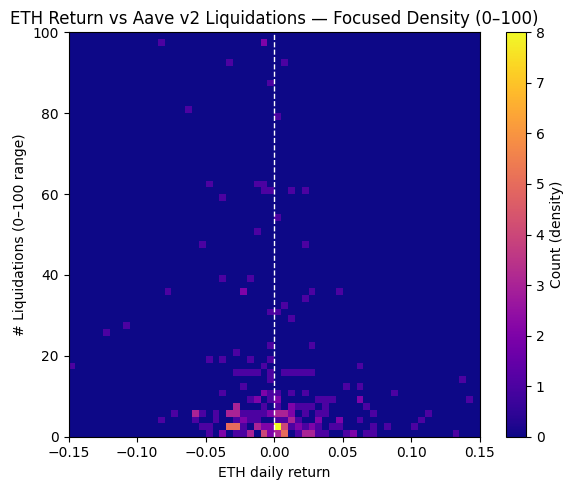

In [50]:
plt.figure(figsize=(6,5))
plt.hist2d(
    m["ret"], m["liq_cnt"],
    bins=[60, 60],
    range=[[-0.15, 0.15], [0, 100]],  # 👈 限制纵轴只看 0–100
    cmap="plasma"
)
plt.colorbar(label="Count (density)")
plt.axvline(0, ls="--", lw=1, color="white")
plt.title("ETH Return vs Aave v2 Liquidations — Focused Density (0–100)")
plt.xlabel("ETH daily return")
plt.ylabel("# Liquidations (0–100 range)")
plt.tight_layout()
plt.savefig("figs/ret_vs_liq_hist2d_focus.png", dpi=200)
plt.show()


In [51]:
import pandas as pd, numpy as np
t = merged.copy()
t["side"] = np.where(t["ret"]<0, "down", "up")
summary = t.groupby("side")["liq_cnt"].agg(
    days="count", total="sum", mean="mean", median="median"
)
summary["rate_per_day"] = summary["total"]/summary["days"]
summary


,days,total,mean,median,rate_per_day
side,,,,,
down,121,5541,45.793388,7.0,45.793388
up,122,2291,18.778689,5.0,18.778689
